# Reproduce Figure 12 of the 2016 JAMES Tracmip introduction paper

We use approach 1 to access the Pangeo data in the Google Cloud. See load_data_from_pangeo.iypnb in the same folder.

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import gcsfs

## Data loading, and then do time mean and spatial mean over last 20 years

Wrapper function to load data. Output is a dictionary of xarray data arrays.

In [2]:
def load_data(freq, var, exp):
    df = pd.read_csv('https://storage.googleapis.com/cmip6/tracmip.csv')
    # a somewhat cumbersome way to query the dataframe ... 
    df_var = df.query("frequency == \'"+freq+"\'").query("variable == \'"+var+"\'").query("experiment == \'"+exp+"\'")
    gcs = gcsfs.GCSFileSystem(token='anon')
    datadict = dict()
    for zstore in df_var.source.values:
        mapper = gcs.get_mapper(zstore)
        ds = xr.open_zarr(mapper, consolidated=True)
         # write only variable of interest to dictionary, so this becomes a data array
        datadict[ds.attrs['model_id']] = ds[var] 
    return datadict

In [3]:
ts_aqct = load_data('Amon', 'ts', 'aquaControl')
ts_aq4x = load_data('Amon', 'ts', 'aqua4xCO2'  )
ts_ldct = load_data('Amon', 'ts', 'landControl')
ts_ld4x = load_data('Amon', 'ts', 'land4xCO2'  )

In [4]:
pr_aqct = load_data('Amon', 'pr', 'aquaControl')
pr_aq4x = load_data('Amon', 'pr', 'aqua4xCO2'  )
pr_ldct = load_data('Amon', 'pr', 'landControl')
pr_ld4x = load_data('Amon', 'pr', 'land4xCO2'  )

Restrict data to last 20 years and average over these as well as over the spatial domain. Note that this will overwrite the dictionaries.

In [5]:
def timemean_globalmean(datadict):
    for model in datadict.keys():
        ds = datadict[model]
        # select only last 20 years and average over them
        ntime = ds.time.size # number of timesteps
        ds = datadict[model].isel(time=slice(ntime-20*12, ntime)).mean('time').compute()
        # spatial mean
        weights = np.cos(np.deg2rad(ds.lat))
        weights.name = "weights"
        ds = ds.weighted(weights).mean(['lat', 'lon']).compute()
        # overwrite dictionary entry with time-mean spatial-mean
        datadict[model] = ds

In [6]:
timemean_globalmean(ts_aqct)
timemean_globalmean(ts_aq4x)
timemean_globalmean(ts_ldct)
timemean_globalmean(ts_ld4x)

In [7]:
timemean_globalmean(pr_aqct)
timemean_globalmean(pr_aq4x)
timemean_globalmean(pr_ldct)
timemean_globalmean(pr_ld4x)

## Plotting

In [8]:
# dictionary for model names, model numbers and model colors used in TRACMIP plots
plotdict = {'AM21'        : {'color': np.array([255,204,153])/255, 'nbr':  '1', 'name': 'AM2.1'       },
            'CAM3'        : {'color': np.array([128,128,128])/255, 'nbr':  '2', 'name': 'CAM3'        },
            'CAM4'        : {'color': np.array([148,255,181])/255, 'nbr':  '3', 'name': 'CAM4'        },
            'CAM5Nor'     : {'color': np.array([194,  0,136])/255, 'nbr':  '4', 'name': 'CAM5Nor'     },
            'CNRM-AM5'    : {'color': np.array([  0, 51,128])/255, 'nbr':  '5', 'name': 'CNRM-AM5'    },
            'ECHAM61'     : {'color': np.array([  0,117,220])/255, 'nbr':  '6', 'name': 'ECHAM6.1'    },
            'ECHAM63'     : {'color': np.array([153, 63,  0])/255, 'nbr':  '7', 'name': 'ECHAM6.3'    },
            'GISS-ModelE2': {'color': np.array([157,204,  0])/255, 'nbr':  '8', 'name': 'GISS-ModelE2'},
            'LMDZ5A'      : {'color': np.array([ 76,  0, 92])/255, 'nbr':  '9', 'name': 'LMDZ5A'      },
            'MetUM-CTL'   : {'color': np.array([ 25, 25, 25])/255, 'nbr': '10', 'name': 'MetM-CTL'    },
            'MetUM-ENT'   : {'color': np.array([  0, 92, 49])/255, 'nbr': '11', 'name': 'MetUM-ENT'   },
            'MIROC5'      : {'color': np.array([ 43,206, 72])/255, 'nbr': '12', 'name': 'MIROC5'      },
            'MPAS'        : {'color': np.array([143,124,  0])/255, 'nbr': '13', 'name': 'MPAS'        },
            'CALTECH'     : {'color': np.array([255,164,  5])/255, 'nbr': '14', 'name': 'CALTECH'     }}

In [9]:
import matplotlib.pyplot as plt
from matplotlib import cm

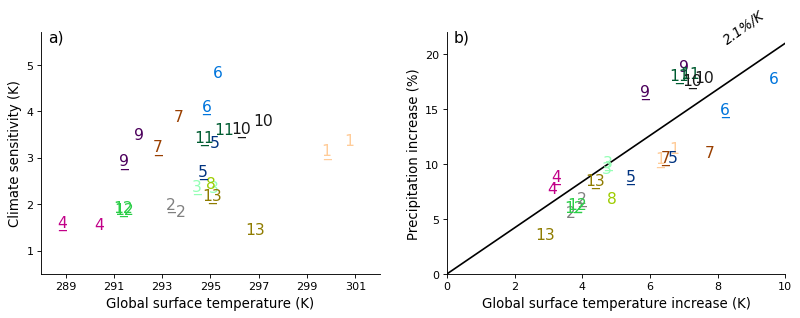

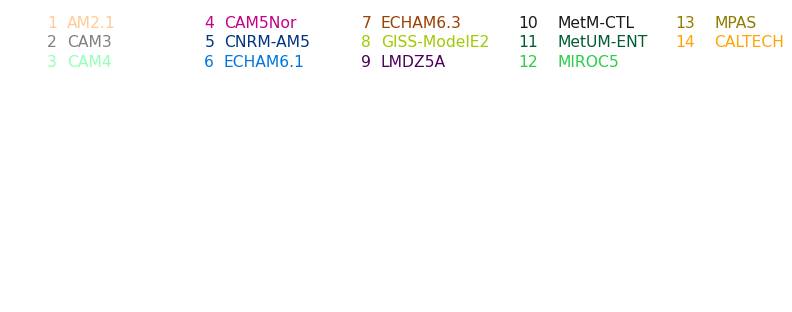

In [10]:
plt.figure( figsize=(12, 4), dpi=80, facecolor='w', edgecolor='k' )

ax = plt.subplot(1, 2, 1)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

for model in ts_aq4x.keys():
    plt.text(ts_aqct[model], 0.5*(ts_aq4x[model] - ts_aqct[model]), plotdict[model]['nbr'], fontweight='normal', color=plotdict[model]['color'], 
             ha='center', va='center', fontsize=14)
for model in ts_ld4x.keys():
    plt.text(ts_ldct[model], 0.5*(ts_ld4x[model] - ts_ldct[model]), plotdict[model]['nbr'], fontweight='normal', color=plotdict[model]['color'],
             ha='center', va='center', fontsize=14)             
    plt.text(ts_ldct[model], 0.5*(ts_ld4x[model] - ts_ldct[model]) - 0.17, '_', fontweight='normal', 
             color=plotdict[model]['color'], ha='center', va='bottom', fontsize=14)
plt.xlim(288, 302), plt.ylim(0.5, 5.7)

plt.xlabel('Global surface temperature (K)', fontsize=12)
plt.ylabel('Climate sensitivity (K)', fontsize=12)
ax.xaxis.set_ticks([289, 291, 293, 295, 297, 299, 301])
ax.xaxis.set_ticklabels([289, 291, 293, 295, 297, 299, 301], fontsize=10)
ax.yaxis.set_ticks([1, 2, 3, 4, 5])
ax.yaxis.set_ticklabels([1, 2, 3, 4, 5], fontsize=10)
plt.text(0.02, 0.98, 'a)', fontsize=14, ha='left', va='center', transform=ax.transAxes)

ax = plt.subplot(1, 2, 2)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

xfit = np.linspace(0, 15, 100)
yfit = 2.1*xfit; plt.plot(xfit, yfit, 'k')
for model in ts_aq4x.keys():
    plt.text((ts_aq4x[model]-ts_aqct[model]), 100*(pr_aq4x[model]-pr_aqct[model])/pr_aqct[model], 
             plotdict[model]['nbr'], fontweight='normal', color=plotdict[model]['color'], ha='center', va='center', fontsize=14)
for model in ts_ld4x.keys():
    plt.text((ts_ld4x[model]-ts_ldct[model]), 100*(pr_ld4x[model]-pr_ldct[model])/pr_ldct[model], 
             plotdict[model]['nbr'], fontweight='normal', color=plotdict[model]['color'], ha='center', va='center', fontsize=14)
    plt.text((ts_ld4x[model]-ts_ldct[model]), 100*(pr_ld4x[model]-pr_ldct[model])/pr_ldct[model] - 0.7, '_', 
             fontweight='normal', color=plotdict[model]['color'], ha='center', va='bottom', fontsize=14)
plt.xlim(0, 10); plt.ylim(0, 22)

plt.xlabel('Global surface temperature increase (K)', fontsize=12)
plt.ylabel('Precipitation increase (%)', fontsize=12)
ax.xaxis.set_ticks([0, 2, 4, 6, 8, 10])
ax.xaxis.set_ticklabels([0, 2, 4, 6, 8, 10], fontsize=10)
ax.yaxis.set_ticks([0, 5, 10, 15, 20])
ax.yaxis.set_ticklabels([0, 5, 10, 15, 20], fontsize=10)
plt.text(0.02, 0.98, 'b)', fontsize=14, ha='left', va='center', transform=ax.transAxes)

plt.text(8.1, 21, '2.1%/K', fontsize=12, fontstyle='italic', rotation=90/2.5)

# plot model names and numbers
plt.figure( figsize=(16, 4), dpi=80, facecolor='w', edgecolor='k' )
plt.xlim(0, 1), plt.ylim(0, 1)
plt.axis('off')
ystart=1.0
delta=0.0666
for model in ts_aqct.keys():
    if np.int(plotdict[model]['nbr'])<4:
        plt.text(0.1 , ystart-delta*np.float(plotdict[model]['nbr']), plotdict[model]['nbr'], color=plotdict[model]['color'], fontsize=14)
        plt.text(0.15, ystart-delta*np.float(plotdict[model]['nbr']), plotdict[model]['name'], color=plotdict[model]['color'], fontsize=14)
    elif np.int(plotdict[model]['nbr'])<7:
        plt.text(0.5 , ystart-delta*(np.float(plotdict[model]['nbr'])-3), plotdict[model]['nbr'], color=plotdict[model]['color'], fontsize=14)
        plt.text(0.55, ystart-delta*(np.float(plotdict[model]['nbr'])-3), plotdict[model]['name'], color=plotdict[model]['color'], fontsize=14)
    elif np.int(plotdict[model]['nbr'])<10:
        plt.text(0.9 , ystart-delta*(np.float(plotdict[model]['nbr'])-6), plotdict[model]['nbr'], color=plotdict[model]['color'], fontsize=14)
        plt.text(0.95, ystart-delta*(np.float(plotdict[model]['nbr'])-6), plotdict[model]['name'], color=plotdict[model]['color'], fontsize=14)
    elif np.int(plotdict[model]['nbr'])<13:
        plt.text(1.3 , ystart-delta*(np.float(plotdict[model]['nbr'])-9), plotdict[model]['nbr'], color=plotdict[model]['color'], fontsize=14)
        plt.text(1.4 , ystart-delta*(np.float(plotdict[model]['nbr'])-9), plotdict[model]['name'], color=plotdict[model]['color'], fontsize=14)
    elif np.int(plotdict[model]['nbr'])<15:
        plt.text(1.7 , ystart-delta*(np.float(plotdict[model]['nbr'])-12), plotdict[model]['nbr'], color=plotdict[model]['color'], fontsize=14)
        plt.text(1.8 , ystart-delta*(np.float(plotdict[model]['nbr'])-12), plotdict[model]['name'], color=plotdict[model]['color'], fontsize=14)

plt.tight_layout()